# REINFORCEMENT LEARNING

### Author: Hyungjoo Kim

##### All data was provided by University College London, Department of Computer Science, Reinforcement Learning Module

##### Supervisor: Prof. Hado Van Hasselt, Matteo Hessel, and Diana Borsa

# Part 2: Deep RL 
You will be guided through the implementation of a full deep reinforcement learning agent.

## 2A) Actor-critics

You are going to implement an Actor-critic agent that updates a policy parametrised as a deep neural network.

The agent learns online from a single stream of experience, updating the parametes of its policy after each transition in the environment.

### Install packages

In [11]:
!git clone https://github.com/deepmind/bsuite.git
!pip install bsuite/
!pip install dm-haiku

fatal: destination path 'bsuite' already exists and is not an empty directory.
Processing ./bsuite
  Created wheel for bsuite: filename=bsuite-0.3.5-py3-none-any.whl size=249668 sha256=188c2f9233ef5ed829434d6a63f08bfd904b16863373e8302088dd29cf3665be
  Stored in directory: /tmp/pip-ephem-wheel-cache-mqmnhl96/wheels/5f/3d/04/cf2b2795a7240c1c4b24a7187390931b2df1dad27772de0f9c
Successfully built bsuite
  Attempting uninstall: bsuite
    Found existing installation: bsuite 0.3.5
    Uninstalling bsuite-0.3.5:
      Successfully uninstalled bsuite-0.3.5


### Imports

In [63]:
from bsuite.environments import catch

import jax
import jax.numpy as jnp
import haiku as hk

import numpy as np
import matplotlib.pyplot as plt

### Plotting

In [64]:
def plot_learning_curve(list_of_episode_returns):
  """Plot the learning curve."""
  plt.figure(figsize=(7, 5))

  def moving_average(x, w):
      return np.convolve(x, np.ones(w), 'valid') / w

  smoothed_returns = moving_average(list_of_episode_returns, 30)
  plt.plot(smoothed_returns)

  plt.xlabel('Average episode returns')
  plt.xlabel('Number of episodes')

  ax = plt.gca()
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(True)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')

### Neural networks

You will now use JAX to define a network parametrising:

* The values of each state $v_{\pi}(s)$.
* The action preferences in each state $\{p_i(s)\}_{i\in\{1, ..., |A|\}}$ (you can think of and implement the preferences $\mathbf{p}(s)$ as a vector output with $|A|$ elements).

You will use `Haiku` (https://github.com/deepmind/dm-haiku) to define the network. You will need to:
* define the forward pass of the network as some function `fn`
* Use `hk.transform(fn)` to convert this in a pair of functions (`init_net`, and `apply_net`):

The `init` function has signature `parameters = init_net(key, obs)`. 
  * takes a `jax.random.PRNGKey` and an `observation`
  * returns randomly sampled weights for the neural network.

The `apply_net` functions have signature `v, p = apply_net(parameters, key, obs)` 
  * takes the current set of `parameters`, a `jax.random.PRNGKey` and an `observation`
  * returns a scalar value `v` and a vector of preferences `p`

### Q 3.1 

Define the forward pass of the neural network. The network must:

* take an `observation` as input
* reshape the observation into a flat vector `flat_obs`
* compute a hidden representation `h = Relu(W.dot(flat_obs) + b)`
* compute a vector of action preferences as a linear function of `h`
* compute a scalar state value as a linear function of `h`
* return the scalar value and vector preferences.

Note:
* The hidden layer should have 50 units
* the action preferences should be a vector of 3 elements (one per each available action),
* the value should be a scalar (not a vector with one element).


In [65]:
def forward_pass(observation):
    flat_obs = lambda x: jnp.reshape(x, (-1, ))
    network = hk.Sequential([
        flat_obs,
        hk.Linear(50),
        jax.nn.relu
    ])    
    # Compute a hidden representation
    h = network(observation)
    # Compute a vector of action preferences as a linear function of h
    action_preferences = hk.Linear(3)(h)
    # Compute a scalar state value as a linear function of h
    value = hk.Linear(1)(h).squeeze(axis = -1)
    return action_preferences, value

init_net, apply_net = hk.transform(forward_pass)

### Choosing actions

A critical component of an actor-critic agent is a (stochastic) policy, mapping `observations` to `actions`. 

In deep RL, this mapping is conventionally parametrised by a deep neural network.

### Q 3.2 

Implement a softmax policy parametrised by the neural network above (i.e., using the `apply_net` function).

The function has signature `action = softmax_policy(net_params, key, obs)`,
* Taking the current network parameters `net_params`, a JAX random `key` and the current `observation`
* Returning an `action` sampled from a softmax distribution (with temperature 1.) over the set of preferences output by the neural network.

Functions to perform random sampling in JAX (e.g. those in `jax.random`) take a random key as input, and they are deterministic function of such a key. In general, in a JAX program you will therefore need to use the `split` function to generate a new random key before every new sampling. The run loop that runs the experiment later on splits the key between consecutive calls to the `policy`. Thus you can assume that a new random `key` is provided to you on each call to the `policy`, however if you need a random key in multiple places within the `policy`, do remember to split the key before each use.

In [66]:
@jax.jit
def softmax_policy(net_params, key, obs):
  """Sample action from a softmax policy."""
  preferences, value = apply_net(net_params, key, obs)
  softmax_policy = jax.nn.softmax(preferences)
  action = jax.random.choice(key, jnp.arange(len(preferences)), p = softmax_policy)
  return action

### Learning values and policies

An actor-critic agent requires to update the parameters of the network so as to simultaneously improve the value predictions and the policy.

In the next section you will define the gradient updates for each of these two components.

### Q 3.3

Implement a function to compute a stochastic estimate of the policy gradient from a 1 step transition in the environment.

* You will use $R_{t+1} + \gamma v(S_{t+1})$ as an estimate of $q_{\pi}(S_t, A_t)$
* You will use $v(S_{t})$ as a baseline to reduce the variance of the updates.

The function must have signature `grads = policy_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * the parameters `net_params` of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and environment discount `discount_t` 
  * and the following observation `obs_t`
* Returns a stochastic estimate of the policy gradient.
  * `grads` has the same structure as `net_params`
  * as it contains an estimate of the gradient of the expected episodic return wrt to each parameter 

In [68]:
def policy_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    # A stochastic estimate of the policy gradient using the computed policy
    grads = jax.grad(policy)(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t)
    return grads

def policy(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    # Compute the scalar value and vector perferences using an observation
    preferences, value = apply_net(net_params, key, obs_tm1)
    # Compute the scalar value and vector preferences using the following observation
    next_p, next_v = apply_net(net_params, key, obs_t)
    # Compute the policy 
    computed_policy = jax.lax.stop_gradient(r_t + discount_t * next_v - value) * jax.nn.log_softmax(preferences)[a_tm1]
    return computed_policy

### Q 3.4 

Implement a function to compute a stochastic estimate of the negative gradient of the value loss:   $ L(\theta) = E_{s \sim \pi}[(v_{\theta}(s) - v_{\pi}(s))^2]$

As for the policy gradient, this must be computed from a 1 step transition in the environment, so using bootstrapping after one step.

It must have signature `neg_grads = neg_value_loss_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * the current parameters `net_params` of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and environment discount `discount_t` 
  * and the following observation `obs_t`
* Returns a stochastic estimate of the policy gradient.
  * `neg_grads` has the same structure as `net_params`
  * as it contains a stochastic estimate of the negative gradient of the expected value prediction loss 

In [69]:
def neg_value_loss_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    # A stochastic estimate of the negative gradient of the value loss using computed loss function from the bottom side
    neg_grads = jax.grad(loss)(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t)
    return neg_grads

def loss(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    # Compute the scalar value and vector perferences using an observation
    preferences, value = apply_net(net_params, key, obs_tm1)
    # Compute the scalar value and vector preferences using the following observation
    next_p, next_v = apply_net(net_params, key, obs_t)
    # Compute the Loss function
    value_loss = -0.5 * (value - jax.lax.stop_gradient(r_t + discount_t * next_v))**2
    return value_loss

### Updating shared parameters

The policy gradient identifies the direction of change in the parameters that most steeply improve the policy.
The negative gradient of the value loss identifies the direction of change in the parameters that most steeply improves the value predictions.

However, note that the value and policy share some of the parameters of the network.  How do we combine the two gradient updates?

In this assignment, we will simply sum the policy and value components.
The function that combines the two gradients is implemented for you in the cell below.

In [70]:
@jax.jit
def compute_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  k1, k2 = jax.random.split(key, 2)
  pgrads = policy_gradient(net_params, k1, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  vgrads = neg_value_loss_gradient(net_params, k2, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_multimap(lambda pg, vg: pg + vg, pgrads, vgrads)

### Optimisation

The gradient updates are typically rescaled to avoid taking too large a step on a single update.
For instance given a candidate gradient update $\nabla$ we may update our parameters $\theta$ by;
$$\Delta \theta = \theta + \alpha * \nabla\,,$$
where $\alpha$ is a small number between 0 and 1 (e.g., $\alpha=0.01$ or $\alpha=0.001$), referred to as `step_size` or `learning_rate`

The gradients with respect to each weight of a neural network may however have very different magnitudes. This can make it hard to set a suitable learning rate $\alpha$.

In deep learning, and deep RL, we typically use adaptive learning rates, for instance by rescaling each component of the gradient using statistics tracking the typical size of the updates to that weight. Then the entire update is rescaled using a global `learning_rate` $\alpha$


### Q 3.5

A popular approach to adaptive gradient rescaling was introduced by the `Adam` algorithm.
* See [Kingma et al, 2014](https://arxiv.org/abs/1412.6980) for references.

This algorithm implements the following procedure before applying each update:
* Increase an update counter $k \gets k+1$ (starting at k=0 before any updates),
* Update the first moment of each gradient component $\mu \gets (1 - \eta) g + \eta \mu$ where $g$ is the latest stochastic gradient.
* Update the second moment of each gradient component $\nu_i = (1 - \eta) g_i ^ 2 + \eta \nu_i $ where $g$ is the latest gradient update.
* Use the following update to update the weights:
$$\Delta w = \alpha \frac{\mu / (1 - \beta_1 ^ {k})}{\epsilon + \sqrt{\nu / (1 - \beta_1 ^ {k})}}$$
* $\alpha$ is a global `learning rate`
* $\beta_1$ and $\beta_2$ define a soft horizon for the per-weight statistics.
* $\epsilon$ makes the rescaling more robust to numerical issues.

In the next cell define a pair of functions (`opt_init`, and `opt_update`), where:

The `opt_init` function has signature `state = opt_init(params)`.
* Takes the network parameters as inputs
* Initialises an `optimiser state` holding the per weight statistics.

The `opt_update` function has signature `updates, state = opt_update(grads, state)`.
* Takes a `gradient` and an `optimisers state`,
* and returns the transformed gradient and the updated `optimiser state`.

Set the algorrithm's hyper-parameters to:
* $\beta_1=.9$ and $\beta_2=.999$, $\epsilon=1e-8$.

In [1]:
# Define the necessary parameters
# The learning rate should be between 0.01 and 0.001.
learning_rate = 0.0019 # I think that 0.0019 ~ 0.002 is the best value because the graph can converge to 1.0 properly
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8

def opt_init(params):
    # Initialise the first moment of each gradient component
    mu = jax.tree_multimap(jnp.zeros_like, params)
    # Initialise the second moment of each gradient component
    v = jax.tree_multimap(jnp.zeros_like, params)
    # Starting at k=0 before any updates
    k = 0
    return mu, v, k

def opt_update(grads, state):
    # Define moment, second moment, counter to state
    mu, v, k = state
    # Increase an update counter k <- K+1
    k += 1
    # Update the first moment of each gradient component
    mu = jax.tree_multimap(lambda x, y: (1 - beta_1) * x + beta_1 * y, grads, mu)
    # Update the second moment of each gradient component
    v = jax.tree_multimap(lambda x, y: (1 - beta_2) * jnp.square(x) + beta_2 * y, grads, v)
    
    # Bias corrected
    mu_hat = jax.tree_multimap(lambda x: x / (1 - beta_1**k), mu)
    v_hat = jax.tree_multimap(lambda x: x / (1 - beta_2**k), v)
    
    # Update the weights
    delta_weight = jax.tree_multimap(lambda x, y: learning_rate * x / (epsilon + jnp.sqrt(y)), mu, v)
    
    # Update the state
    state = mu, v, k
    return delta_weight, state

### Run experiments

Run the cell below to show the performance of the resulting agent.

You may also use this section for debugging your implementations.

Note however, that most functions are `jitted` for performance,
* either using the `@jax.jit` decorator in the function definition
* or calling explicitely `fn = jax.jit(fn)`

When jitting, the code is compiled on the first time the function is executed
* and execution is much faster on subsequent calls.
* a notable side effect is that print statements in a jitted function will only execute on the first execution of the function.
* to drop into a debugger or print on each function execution you will have to disable the `@jax.jit` annotations and jax.jit calls.

Training agent for 1500 episodes...


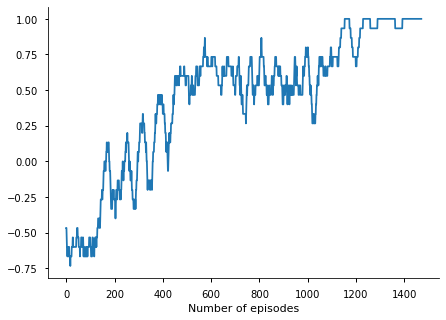

In [72]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 1500
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = jax.random.PRNGKey(44)
rng, init_rng = jax.random.split(rng)
sample_input = env.observation_spec().generate_value()
net_params = init_net(init_rng, sample_input)

# Initialize optimizer state.
opt_state = opt_init(net_params)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_multimap(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = softmax_policy(net_params, policy_rng, obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = softmax_policy(net_params, policy_rng, new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount
    rng, grad_rng = jax.random.split(rng)
    dJ_dtheta = compute_gradient(
        net_params, grad_rng, obs_tm1, a_tm1, r_t, discount_t, 
        new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    net_params = apply_updates(net_params, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

# Plot learning curve.
plot_learning_curve(all_episode_returns)

In [11]:
# Part 2A average return in the last 100 episode
np.mean(all_episode_returns[-100:]) 

1.0

In [12]:
# Part 2A average return in the whole episode
np.mean(all_episode_returns[-1500:]) 

0.44133333333333336

## 2B) An alternative update

You are going to implement a different kind of agent.

Like an actor-critic, it learns online from a single stream of experience, updating the parametes after each transition in the environment.

### Neural networks


The agent will reuse the same neural network we defined for the actor-critic:
* the scalar output will be trained via TD to estimate state values
* the vector preferences `p` will be updated according to a different rule.

### Choosing actions

As in actor-critics, the (stochastic) mapping from `observations` to `actions` depends on the vector of preferences `p` from the network.

### Q 3.6

The new agent's policy will have the signature `action = epsilon_greedy_policy(net_params, key, obs)`,
* Take as inputs the current network parameters `net_params`, a JAX random `key` and the current `observation`
* Return with probability `0.9` the greedy `action` with respect to the preferences `p`, ties must be broken at random.
* Return an action uniformly at random with probability `0.1`

In [74]:
@jax.jit
def epsilon_greedy_policy(net_params, key, obs):
  """Sample action from an epsilon-greedy policy."""
  # Compute the scalar value and vector perferences using an observation
  preferences, value = apply_net(net_params, key, obs)
  
  # Return an action uniformly at random with probability 0.1
  if np.random.rand() <= 0.1:
    return jax.random.uniform(key)
  # Return with probability 0.9 the greedy action w.r.t the preferences
  else:
    return jnp.argmax(preferences)

### Q 3.7 

The preferences `p` will be update according to the following gradient-based update:

* ($R_{t+1} + \gamma v(S_{t+1}) - p(S_{t}, A_t)) \nabla p(S_t, A_t))$ 
* where `v` is the state value trained by TD as in the actor critic.

You musy implement this in the function `preference_gradient`, with the same signature as `policy_gradient`

In [75]:
def preference_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  # Compute the preferences gradient based update  
  p_grads = jax.grad(preferences)(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return p_grads

def preferences(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  # Compute the scalar value and vector perferences using an observation
  preferences, value = apply_net(net_params, key, obs_tm1)
  # Compute the scalar value and vector perferences using the following observation
  next_p, next_v = apply_net(net_params, key, obs_t)
  # Compute the preference for the above equation
  computed_p = jax.lax.stop_gradient(r_t + discount_t * next_v - preferences[a_tm1]) * preferences[a_tm1]
  return computed_p

### Updating shared parameters

Just like in the actor critic the overall update to the parameters is a combination of two quantities:
* the new update we defined for the vector of preferences
* the same TD update to the scalar output that we used in the actor critic

In [76]:
@jax.jit
def compute_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  k1, k2 = jax.random.split(key, 2)
  pgrads = preference_gradient(net_params, k1, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  vgrads = neg_value_loss_gradient(net_params, k2, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_multimap(lambda pg, vg: pg + vg, pgrads, vgrads)

### Optimisation

The gradient updates are rescaled using the same optimiser used for the actor-critic.

### Run experiments

Run the cell below to show the performance of the new agent.

Training agent for 1500 episodes...


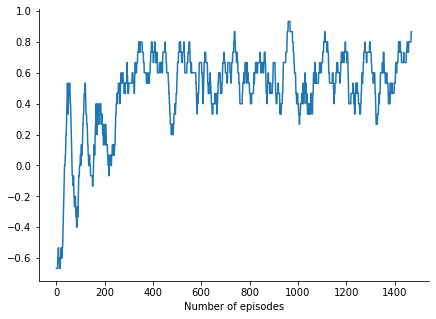

In [16]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 1500
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = jax.random.PRNGKey(44)
rng, init_rng = jax.random.split(rng)
sample_input = env.observation_spec().generate_value()
net_params = init_net(init_rng, sample_input)

# Initialize optimizer state.
opt_state = opt_init(net_params)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_multimap(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = epsilon_greedy_policy(net_params, policy_rng, obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = epsilon_greedy_policy(net_params, policy_rng, new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount
    rng, grad_rng = jax.random.split(rng)
    dJ_dtheta = compute_gradient(
        net_params, grad_rng, obs_tm1, a_tm1, r_t, discount_t, 
        new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    net_params = apply_updates(net_params, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

# Plot learning curve.
plot_learning_curve(all_episode_returns)

In [17]:
# Part 2B average return in the last 100 episode
np.mean(all_episode_returns[-100:]) 

0.7

In [18]:
# Part 2B average return in the whole episode
np.mean(all_episode_returns[-1500:]) 

0.4866666666666667

### Q 3.8 

[1pts]: What is the best asymptotic average return that can be achieved by the actor-critic agent described in `Part 2A)`?

> In part 2A, the plot looks fully convergence to 1.0 during the 1500 number of episodes, so the best asymptotic average return is 1.0. The average return from the whole episodes (1500 episodes) is computed in the bottom of the figure 2A, and the average return is 0.4413.

[1pts] What is the best asymptotic average return that can be achieved by the second agent described in `Part 2B)`?

> In part 2B, the plot looks not fully convergence to 1.0, but it can be if the number of episodes is more than 1500 (e.g. 2000). The best asymptotic average return from the above figure is approximately 0.9 during the 1500 number of episodies. The average return from the last 100 episodes and whole episodes (1500 episodes) are computed in the above of this cell, and the average returns are 0.7 and 0.487, respectively.

[2pts] What quantity do the preferences `p` estimate in the second agent described in `Part 2B)`?

> The preferences `p` would estimate the value determined by given policy, state, and action.